In [1]:
import pandas as pd
import numpy as np
import requests
import shelve
import os
from datetime import datetime
import matplotlib.pyplot as plt
import re

In [2]:
user="Lilian"
#user in personal pc1 <- "asus"

In [3]:
class NDCATCProcessor:

    def __init__(self, year, base_path=None):
        self.year = year
        self.base_path = base_path or rf"c:\Users\{user}\OneDrive - purdue.edu\VS code\Data"
        self.df_cleaned = None
        self.df_merged = None
        self.atc_mapping = None
        
    def clean_sdud_data(self):

        csv_file = os.path.join(self.base_path, f"SDUD\\SDUD{self.year}.csv")
        print(f"Reading CSV: {csv_file}")
        
        df = pd.read_csv(csv_file, dtype={'NDC': 'object'})
        print(f"Initial rows: {len(df):,}")
        
        # Filter data
        df_filtered = df.dropna(subset=['Units Reimbursed', 'Number of Prescriptions']) #dropping na values
        df_filtered = df_filtered[df_filtered['State'] != 'XX']
        
        print(f"After cleaning: {len(df_filtered):,} rows, {df_filtered['NDC'].nunique():,} unique NDCs")
        
        self.df_cleaned = df_filtered
        return self.df_cleaned
    
    def adding_key(self):
        if self.df_cleaned is None:
            raise ValueError("Run clean_sdud_data() first")
        
        self.df_cleaned['record_id'] = (
            self.df_cleaned['State'].astype(str) + "_" +
            self.df_cleaned['Year'].astype(str) + "_" +
            self.df_cleaned['Quarter'].astype(str) + "_" +
            self.df_cleaned['Utilization Type'].astype(str) + "_" +
            self.df_cleaned['NDC'].astype(str)
        )
        
        print(f"Created {len(self.df_cleaned):,} record IDs")
        return self.df_cleaned
    
    def generate_ndc_txt(self, output_filename=None):
        if 'record_id' not in self.df_cleaned.columns:
            raise ValueError("Run adding_key() first")
            
        output_filename = output_filename or f"NDCNEW_{self.year}.txt"
        output_path = os.path.join(self.base_path, f"ATC\\text_files\\{output_filename}")
        
        unique_pairs = self.df_cleaned[['NDC', 'record_id']].drop_duplicates()
        
        with open(output_path, 'w') as f:
            f.write("NDC\trecord_id\n")
            for _, row in unique_pairs.iterrows():
                f.write(f"{row['NDC']}\t{row['record_id']}\n")
        
        print(f"Exported {unique_pairs['record_id'].nunique():,} unique records to {output_path}")
        return output_path
    
    def analyze_atc4_mapping(self):

        if 'record_id' not in self.df_cleaned.columns:
            raise ValueError("Run adding_key() first")
            
        atc4_path = os.path.join(self.base_path, f"ATC\\ATC4_classes\\NDCNEW_{self.year}_ATC4_classes.csv")
        
        # Load ATC4 mapping
        df_atc4 = pd.read_csv(atc4_path, dtype={'NDC': 'object', 'record_id': 'string'})
        df_atc4['NDC'] = df_atc4['NDC'].str.zfill(11)
        
        print(f"ATC4 file: {len(df_atc4):,} rows, {df_atc4['NDC'].nunique():,} unique NDCs")
        
        # Ensure consistent types
        self.df_cleaned['record_id'] = self.df_cleaned['record_id'].astype('string')
        self.df_cleaned['NDC'] = self.df_cleaned['NDC'].astype('object')
        
        # Merge on both record_id and NDC
        self.atc_mapping = pd.merge(
            self.df_cleaned,
            df_atc4[['record_id', 'NDC', 'ATC4 Class']],
            on=['record_id', 'NDC'],
            how='left'
        )
        #deduplication after merge by record_id
        before_count=len(self.atc_mapping) 
        self.atc_mapping=self.atc_mapping.drop_duplicates(subset='record_id', keep='first')
        
        total = len(self.atc_mapping)
     
        mapped = self.atc_mapping['ATC4 Class'].notna().sum()
        print(f"Merged: {total:,} records, {mapped:,} with ATC4 ({mapped/total*100:.1f}%)")
        
        missing = total - mapped
        if missing > 0:
            print(f"Missing: {missing:,} records, {self.atc_mapping[self.atc_mapping['ATC4 Class'].isna()]['NDC'].nunique():,} unique NDCs")
        
        return self.atc_mapping
    
    def analyze_atc_distribution(self, level='ATC3'):

        if self.atc_mapping is None:
            raise ValueError("Run analyze_atc4_mapping() first")
        
        records = self.atc_mapping[self.atc_mapping['ATC4 Class'].notna()].copy()
        
        if len(records) == 0:
            print("No records with valid ATC4 mappings.")
            return None
        
        # Create ATC level column if needed
        if level == 'ATC3':
            records['ATC3 Class'] = records['ATC4 Class'].str[:4]
            class_col = 'ATC3 Class'
        elif level == 'ATC2':
            records['ATC2 Class'] = records['ATC4 Class'].str[:3]
            class_col = 'ATC2 Class'
        else:
            class_col = 'ATC4 Class'
        
        # Count classes per record_id
        per_record = records.groupby('record_id')[class_col].nunique().reset_index()
        per_record.columns = ['record_id', 'num_classes']
        
        distribution = per_record['num_classes'].value_counts().sort_index()
        
        print(f"\n{level} CLASSES PER RECORD_ID:")
        for n_classes, count in distribution.items():
            pct = (count / len(per_record)) * 100
            print(f"  {n_classes} class(es): {count:,} records ({pct:.1f}%)")
        
        print(f"\nSummary:")
        print(f"  Avg {level} per record: {per_record['num_classes'].mean():.2f}")
        print(f"  Max {level} per record: {per_record['num_classes'].max()}")
        
        return per_record

    def fetch_atc_names(self, cache_path=None):
        """Fetch ATC class names (ATC4, ATC3, ATC2) from RxNav API."""
        if self.atc_mapping is None:
            raise ValueError("Must run analyze_atc4_mapping() first")
        
        if cache_path is None:
            cache_path = os.path.join(self.base_path, "ATC\\cache_files\\atc_names_cache")
        
        print(f"\n{'='*60}")
        print("FETCHING ATC CLASS NAMES")
        print(f"{'='*60}")
        print(f"Using cache: {cache_path}")
        
        # Get only records with valid ATC4 mappings
        df_with_atc = self.atc_mapping[self.atc_mapping['ATC4 Class'].notna()].copy()
        
        # Create ATC3 and ATC2 columns from ATC4
        print("\nCreating ATC3 and ATC2 columns from ATC4...")
        df_with_atc['ATC3 Class'] = df_with_atc['ATC4 Class'].str[:4]
        df_with_atc['ATC2 Class'] = df_with_atc['ATC4 Class'].str[:3]
        
        # Get unique codes for each level
        unique_atc4 = df_with_atc['ATC4 Class'].dropna().unique()
        unique_atc3 = df_with_atc['ATC3 Class'].dropna().unique()
        unique_atc2 = df_with_atc['ATC2 Class'].dropna().unique()
        
        # Filter out invalid codes
        unique_atc4 = [c for c in unique_atc4 if c not in ['No ATC Mapping Found', 'No RxCUI Found', '']]
        unique_atc3 = [c for c in unique_atc3 if c not in ['No ATC Mapping Found', 'No RxCUI Found', '', 'No ', 'No']]
        unique_atc2 = [c for c in unique_atc2 if c not in ['No ATC Mapping Found', 'No RxCUI Found', '', 'No ', 'No']]
        
        print(f"\nUnique codes to fetch:")
        print(f"  ATC4: {len(unique_atc4)}")
        print(f"  ATC3: {len(unique_atc3)}")
        print(f"  ATC2: {len(unique_atc2)}")
        
        # Build mappings
        atc4_names = {}
        atc3_names = {}
        atc2_names = {}
        
        with shelve.open(cache_path) as cache:
            start_time = datetime.now()
            
            print("\nFetching ATC4 names...")
            for code in unique_atc4:
                atc4_names[code] = self._get_atc_name(code, cache)
            
            print("Fetching ATC3 names...")
            for code in unique_atc3:
                atc3_names[code] = self._get_atc_name(code, cache)
            
            print("Fetching ATC2 names...")
            for code in unique_atc2:
                atc2_names[code] = self._get_atc_name(code, cache)
            
            print(f"\nTotal processing time: {(datetime.now() - start_time).total_seconds()/60:.1f} minutes")
        
        # Apply names to all records in atc_mapping
        print("\nApplying names to dataframe...")
        self.atc_mapping['ATC3 Class'] = self.atc_mapping['ATC4 Class'].str[:4]
        self.atc_mapping['ATC2 Class'] = self.atc_mapping['ATC4 Class'].str[:3]
        
        self.atc_mapping['ATC4_Name'] = self.atc_mapping['ATC4 Class'].map(atc4_names).fillna('')
        self.atc_mapping['ATC3_Name'] = self.atc_mapping['ATC3 Class'].map(atc3_names).fillna('')
        self.atc_mapping['ATC2_Name'] = self.atc_mapping['ATC2 Class'].map(atc2_names).fillna('')
        
        print(f"\nATC names added successfully!")
        print("\nSample output:")
        sample = self.atc_mapping[self.atc_mapping['ATC4 Class'].notna()][['NDC', 'record_id', 'ATC4 Class', 'ATC4_Name', 'ATC3 Class', 'ATC3_Name', 'ATC2 Class', 'ATC2_Name']].head(5)
        print(sample.to_string())
        
        return self.atc_mapping
    
    def prepare_final_dataframe(self):

        if self.atc_mapping is None:
            raise ValueError("Run fetch_atc_names() first")
        
        self.df_merged = self.atc_mapping.copy()
        
        # Scale units
        self.df_merged['Units Reimbursed'] = self.df_merged['Units Reimbursed'] / 1e9
        self.df_merged['Number of Prescriptions'] = self.df_merged['Number of Prescriptions'] / 1e6
        
        total = len(self.df_merged)
        mapped = self.df_merged['ATC4 Class'].notna().sum()
        
        print(f"\nFinal Statistics:")
        print(f"  Records: {total:,} ({mapped:,} with ATC4, {mapped/total*100:.1f}%)")
        print(f"  Units Reimbursed: {self.df_merged['Units Reimbursed'].sum():.2f} Billion")
        print(f"  Prescriptions: {self.df_merged['Number of Prescriptions'].sum():.2f} Million")
        
        return self.df_merged
    
    def _get_atc_name(self, atc_code, cache):
        """Helper: Fetch ATC name from RxNav API with caching."""
        cache_key = f"atc_name:{atc_code}"
        if cache_key in cache:
            return cache[cache_key]
        
        try:
            url = f"https://rxnav.nlm.nih.gov/REST/rxclass/class/byId.json?classId={atc_code}"
            response = requests.get(url)
            response.raise_for_status()
            data = response.json()
            
            if 'rxclassMinConceptList' in data and 'rxclassMinConcept' in data['rxclassMinConceptList']:
                concepts = data['rxclassMinConceptList']['rxclassMinConcept']
                if concepts:
                    name = concepts[0].get('className', '')
                    cache[cache_key] = name
                    return name
            
            cache[cache_key] = ''
            return ''
            
        except Exception as e:
            print(f"Error retrieving {atc_code}: {e}")
            cache[cache_key] = ''
            return ''

    def export_merged_data(self, output_filename=None, show_details=True):

        if self.df_merged is None:
            raise ValueError("Run prepare_final_dataframe() first")
            
        output_filename = output_filename or f"merged_NEWdata_{self.year}.csv"
        output_path = os.path.join(self.base_path, f"ATC\\merged_data\\{output_filename}")
        os.makedirs(os.path.dirname(output_path), exist_ok=True)
        
        # Check duplicates
        initial_count = len(self.df_merged)
        duplicate_count = self.df_merged['record_id'].duplicated().sum()
        
        print(f"\nDeduplication Check:")
        print(f"  Before: {initial_count:,} rows")
        print(f"  Duplicates: {duplicate_count:,}")
        
        # Show sample duplicates if requested
        if show_details and duplicate_count > 0:
            dup_records = self.df_merged[self.df_merged['record_id'].duplicated(keep=False)].sort_values('record_id')
            sample_ids = dup_records['record_id'].unique()[:2]
            
            print(f"\nSample duplicate record_ids:")
            for rid in sample_ids:
                sample = self.df_merged[self.df_merged['record_id'] == rid][
                    ['record_id', 'NDC', 'State', 'ATC4 Class', 'ATC2 Class']
                ]
                print(f"\n{rid}:")
                print(sample.to_string(index=False))
        
        # Deduplicate and export
        df_final = self.df_merged.drop_duplicates(subset='record_id', keep='first')
        df_final.to_csv(output_path, index=False)
        
        print(f"\n  After: {len(df_final):,} rows")
        print(f"  Removed: {initial_count - len(df_final):,}")
        print(f"\nExported to: {output_path}")

        #Showing final atc class mapping in %
        final_count = len(df_final)
        final_mapped_records = df_final['ATC4 Class'].notna().sum()
        final_unmapped_records = final_count - final_mapped_records
        final_mapped_ndcs=df_final[df_final['ATC4 Class'].notna()]['NDC'].nunique()
        final_unmapped_ndcs=df_final['NDC'].nunique()
        
        # Aggregate metrics
        agg = df_final.groupby('record_id').agg({
            'Units Reimbursed': 'sum',
            'Number of Prescriptions': 'sum'
        })
        
        print(f"\nAggregated Totals:")
        print(f"  Units Reimbursed: {agg['Units Reimbursed'].sum():.3f} Billion")
        print(f"  Number of Prescriptions: {agg['Number of Prescriptions'].sum():3f} Million")
        
        return output_path
    

In [ ]:
class NDCATC_overview:

    @staticmethod
    def create_multi_year_distribution_analysis(years_list, base_path=None):

        if base_path is None:
            base_path = rf"c:\Users\{user}\OneDrive - purdue.edu\VS code\Data"
            
        print("Creating Multi-Year ATC Distribution Analysis...")
        print("="*70)
        
        results = {
            'ATC4_1_class': {}, 'ATC4_2_classes': {}, 'ATC4_3+_classes': {},
            'ATC3_1_class': {}, 'ATC3_2_classes': {}, 'ATC3_3+_classes': {},
            'ATC2_1_class': {}, 'ATC2_2_classes': {}, 'ATC2_3+_classes': {}
        }
        
        for year in years_list:
            print(f"Processing {year}...", end=" ")
            try:
                # Load the pre-processed CSV file
                csv_path = os.path.join(base_path, f"ATC\\merged_data\\merged_NEWdata_{year}.csv")
                df_merged = pd.read_csv(csv_path)
                
                records = df_merged[df_merged['ATC4 Class'].notna()].copy()
                if records.empty:
                    print("No ATC records")
                    for key in results.keys():
                        results[key][year] = "N/A"
                    continue
                    
                records['ATC2 Class'] = records['ATC4 Class'].str[:3]
                records['ATC3 Class'] = records['ATC4 Class'].str[:4]
                
                # Calculate distributions for each level
                for level, col in [('ATC4', 'ATC4 Class'), ('ATC3', 'ATC3 Class'), ('ATC2', 'ATC2 Class')]:
                    per_record = records.groupby('record_id')[col].nunique()
                    dist = per_record.value_counts().sort_index()
                    total = len(per_record)
                    
                    results[f'{level}_1_class'][year] = f"{(dist.get(1, 0) / total * 100):.1f}%"
                    results[f'{level}_2_classes'][year] = f"{(dist.get(2, 0) / total * 100):.1f}%"
                    results[f'{level}_3+_classes'][year] = f"{(dist[dist.index >= 3].sum() / total * 100):.1f}%"
                
                print("✓")
            except FileNotFoundError:
                print(f"✗ File not found: {csv_path}")
                for key in results.keys():
                    results[key][year] = "N/A"
            except Exception as e:
                print(f"✗ Error: {e}")
                for key in results.keys():
                    results[key][year] = "N/A"
        
        df_percentages = pd.DataFrame(results).T
        print(f"\nATC DISTRIBUTION PERCENTAGES ACROSS YEARS")
        print("="*60)
        print(df_percentages)
        return df_percentages
    
    @staticmethod
    def analyze_general_atc_overview_by_state(years_list, base_path=None, state_filter=None):

        if base_path is None:
            base_path = rf"c:\Users\{user}\OneDrive - purdue.edu\VS code\Data"

        if state_filter:
            if isinstance(state_filter, str):
                state_filter = [state_filter]
            print(f"Creating ATC2 & ATC3 Overview by State for: {', '.join(state_filter)}")
        else:
            print("Creating ATC2 & ATC3 Overview by State (All States)")
        print("="*78)
        
        # Results will be organized by state
        state_results = {}
        all_states = set()
        
        # Collect data for all years first
        for year in years_list:
            print(f"Processing {year}...", end=" ")
            try:
                csv_path = os.path.join(base_path, f"ATC\\merged_data\\merged_NEWdata_{year}.csv")
                df_merged = pd.read_csv(csv_path)
                
                records = df_merged[df_merged['ATC4 Class'].notna()].copy()
                if records.empty:
                    print("No ATC records")
                    continue
                
                # Filter by state if specified
                if state_filter:
                    records = records[records['State'].isin(state_filter)]
                    if records.empty:
                        print(f"No records for states {state_filter}")
                        continue
                    states_to_process = state_filter
                else:
                    states_to_process = records['State'].unique()
                    all_states.update(states_to_process)
                
                for state in states_to_process:
                    state_records = records[records['State'] == state]
                    if state_records.empty:
                        continue
                    
                    # Initialize state data structure
                    if state not in state_results:
                        state_results[state] = {
                            'atc2_year_results': {},
                            'atc3_year_results': {}
                        }
                    
                    # ATC2 summary for this state
                    pairs2 = state_records[['record_id', 'NDC', 'ATC2 Class']].drop_duplicates()
                    atc2_summary = pairs2.groupby('ATC2 Class').agg(
                        Unique_NDCs=('NDC', 'nunique'),
                        Total_Records=('record_id', 'nunique')
                    ).sort_values('Unique_NDCs', ascending=False)
                    atc2_summary['Percentage_of_NDCs'] = (
                        atc2_summary['Unique_NDCs'] / pairs2['NDC'].nunique() * 100
                    ).round(1)
                    
                    # ATC3 summary for this state
                    pairs3 = state_records[['record_id', 'NDC', 'ATC3 Class']].drop_duplicates()
                    atc3_summary = pairs3.groupby('ATC3 Class').agg(
                        Unique_NDCs=('NDC', 'nunique'),
                        Total_Records=('record_id', 'nunique')
                    ).sort_values('Unique_NDCs', ascending=False)
                    atc3_summary['Percentage_of_NDCs'] = (
                        atc3_summary['Unique_NDCs'] / pairs3['NDC'].nunique() * 100
                    ).round(1)
                    
                    state_results[state]['atc2_year_results'][year] = atc2_summary
                    state_results[state]['atc3_year_results'][year] = atc3_summary
                
                processed_states = len([s for s in states_to_process if s in state_results])
                print(f"✓ (States: {processed_states})")
                
            except FileNotFoundError:
                print(f"✗ File not found")
            except Exception as e:
                print(f"✗ Error: {e}")
        
        # Process each state with the same format as original method
        final_state_results = {}
        
        states_to_analyze = state_filter if state_filter else sorted(all_states)
        
        for state in states_to_analyze:
            if state not in state_results:
                continue
                
            print(f"\n" + "="*60)
            print(f"PROCESSING STATE: {state}")
            print("="*60)
            
            atc2_year_results = state_results[state]['atc2_year_results']
            atc3_year_results = state_results[state]['atc3_year_results']
            
            # Print summaries for this state (same format as original)
            print(f"\nUNIQUE NDCs PER ATC2 CLASS BY YEAR - {state}")
            print("="*50)
            for year in years_list:
                if year in atc2_year_results and not atc2_year_results[year].empty:
                    print(f"\n{year}: {len(atc2_year_results[year])} classes, "
                        f"{atc2_year_results[year]['Unique_NDCs'].sum():,} total NDCs")
                    print("Top 10:")
                    print(atc2_year_results[year].head(10))
            
            print(f"\nUNIQUE NDCs PER ATC3 CLASS BY YEAR - {state}")
            print("="*50)
            for year in years_list:
                if year in atc3_year_results and not atc3_year_results[year].empty:
                    print(f"\n{year}: {len(atc3_year_results[year])} classes, "
                        f"{atc3_year_results[year]['Unique_NDCs'].sum():,} total NDCs")
                    print("Top 10:")
                    print(atc3_year_results[year].head(10))
            
            # Build comparison tables (same logic as original)
            def build_comparison(year_tables):
                all_classes = set()
                for tbl in year_tables.values():
                    if not tbl.empty:
                        all_classes.update(tbl.index.tolist())
                comp = {cls: {y: int(year_tables[y].loc[cls, 'Unique_NDCs']) 
                            if y in year_tables and not year_tables[y].empty and cls in year_tables[y].index else 0
                            for y in years_list}
                        for cls in sorted(all_classes)}
                df = pd.DataFrame(comp).T
                return df.loc[df.sum(axis=1).sort_values(ascending=False).index]
            
            atc2_comparison = build_comparison(atc2_year_results)
            atc3_comparison = build_comparison(atc3_year_results)
            
            # Create cumulative frequency tables (same logic as original)
            def create_cumulative_frequency_table(comparison_df, level_name):
                total_ndcs = comparison_df.sum(axis=1).sort_values(ascending=False)
                
                freq_table = pd.DataFrame({
                    'ATC_Class': total_ndcs.index,
                    'Total_Unique_NDCs': total_ndcs.values,
                    'Percentage': (total_ndcs.values / total_ndcs.sum() * 100).round(2)
                })
                
                freq_table['Cumulative_NDCs'] = freq_table['Total_Unique_NDCs'].cumsum()
                freq_table['Cumulative_Percentage'] = freq_table['Percentage'].cumsum().round(2)
                
                freq_table.reset_index(drop=True, inplace=True)
                freq_table.index = freq_table.index + 1
                
                return freq_table
            
            atc2_freq_table = create_cumulative_frequency_table(atc2_comparison, 'ATC2')
            atc3_freq_table = create_cumulative_frequency_table(atc3_comparison, 'ATC3')
            
            # Store results for this state
            final_state_results[state] = {
                'atc2_year_results': atc2_year_results,
                'atc3_year_results': atc3_year_results,
                'atc2_comparison': atc2_comparison,
                'atc3_comparison': atc3_comparison,
                'atc2_freq_table': atc2_freq_table,
                'atc3_freq_table': atc3_freq_table
            }
        
        return final_state_results
    
    @staticmethod
    def get_atc_ndc_details(year, top_n=10, base_path=None):
    
        if base_path is None:
            base_path = rf"c:\Users\{user}\OneDrive - purdue.edu\VS code\Data"
            
        print(f"Analyzing ATC-NDC details for {year}...")
        print("="*60)
        
        try:
            # Load the pre-processed CSV file
            csv_path = os.path.join(base_path, f"ATC\\merged_data\\merged_NEWdata_{year}.csv")
            df_merged = pd.read_csv(csv_path)
            
            records = df_merged[df_merged['ATC4 Class'].notna()].copy()
            if records.empty:
                print("No records with ATC mapping")
                return pd.DataFrame(), pd.DataFrame()
                
            records['ATC2 Class'] = records['ATC4 Class'].str[:3]
            records['ATC3 Class'] = records['ATC4 Class'].str[:4]
            
            # ATC2 details
            atc2_details = records.groupby('ATC2 Class').agg(
                Unique_NDCs=('NDC', 'nunique'),
                Total_Records=('record_id', 'nunique')
            ).sort_values('Unique_NDCs', ascending=False).head(top_n)
            
            # ATC3 details
            atc3_details = records.groupby('ATC3 Class').agg(
                Unique_NDCs=('NDC', 'nunique'),
                Total_Records=('record_id', 'nunique')
            ).sort_values('Unique_NDCs', ascending=False).head(top_n)
            
            print(f"\nTop {top_n} ATC2 Classes:")
            print(atc2_details)
            print(f"\nTop {top_n} ATC3 Classes:")
            print(atc3_details)
            
            return atc2_details, atc3_details
            
        except FileNotFoundError:
            print(f"✗ File not found: {csv_path}")
            return pd.DataFrame(), pd.DataFrame()
        except Exception as e:
            print(f"✗ Error: {e}")
            return pd.DataFrame(), pd.DataFrame()
    
    @staticmethod
    def export_cumulative_frequency_excel(years_list, level='ATC2', base_path=None, output_filename=None, include_ndc_counts=True, by_state=False, state_filter=None):
        
        if base_path is None:
            base_path = rf"c:\Users\{user}\OneDrive - purdue.edu\VS code\Data"
        
        # Handle state filtering messaging
        if by_state:
            if state_filter:
                if isinstance(state_filter, str):
                    state_filter = [state_filter]
                print(f"Creating {level} Cumulative Frequency Analysis Excel for States: {', '.join(state_filter)}")
            else:
                print(f"Creating {level} Cumulative Frequency Analysis Excel by State (All States)")
        else:
            print(f"Creating {level} Cumulative Frequency Analysis Excel...")
        print("="*70)
        
        if by_state:
            # State-based analysis
            state_year_results = {}
            state_ndc_counts = {}
            all_states = set()
        else:
            # Original total analysis
            year_results = {}
            ndc_counts = {}  # Store NDC counts for each ATC class
        
        # Step 1: Process each year and collect both financial and NDC count data
        for year in years_list:
            print(f"Processing {year}...", end=" ")
            try:
                csv_path = os.path.join(base_path, f"ATC\\merged_data\\merged_NEWdata_{year}.csv")
                df_merged = pd.read_csv(csv_path)
                
                records = df_merged[df_merged['ATC4 Class'].notna()].copy()
                if records.empty:
                    print("No ATC records")
                    if by_state:
                        # Initialize empty for this year
                        pass
                    else:
                        year_results[year] = pd.DataFrame()
                        ndc_counts[year] = pd.DataFrame()
                    continue
                
                # Filter by state if specified
                if by_state and state_filter:
                    records = records[records['State'].isin(state_filter)]
                    if records.empty:
                        print(f"No records for states {state_filter}")
                        continue
                
                # Create appropriate ATC level column
                if level == 'ATC2':
                    records['ATC_Level'] = records['ATC4 Class'].str[:3]
                elif level == 'ATC3':
                    records['ATC_Level'] = records['ATC4 Class'].str[:4]
                else:  # ATC4
                    records['ATC_Level'] = records['ATC4 Class']
                
                if by_state:
                    # Group by state first
                    if state_filter:
                        states_to_process = state_filter
                    else:
                        states_to_process = records['State'].unique()
                        all_states.update(states_to_process)
                    
                    for state in states_to_process:
                        state_records = records[records['State'] == state]
                        if state_records.empty:
                            continue
                        
                        # Initialize state dictionaries if needed
                        if state not in state_year_results:
                            state_year_results[state] = {}
                            state_ndc_counts[state] = {}
                        
                        # Aggregate financial data by ATC level for this state
                        financial_summary = state_records.groupby('ATC_Level').agg(
                            Units_Reimbursed=('Units Reimbursed', 'sum'),
                            Number_of_Prescriptions=('Number of Prescriptions', 'sum')
                        )
                        
                        # Count unique NDCs by ATC level for this state
                        ndc_count_summary = state_records.groupby('ATC_Level').agg(
                            Unique_NDCs=('NDC', 'nunique')
                        )
                        
                        state_year_results[state][year] = financial_summary
                        state_ndc_counts[state][year] = ndc_count_summary
                    
                    print(f"✓ (States: {len(states_to_process)})")
                else:
                    # Original total analysis
                    financial_summary = records.groupby('ATC_Level').agg(
                        Units_Reimbursed=('Units Reimbursed', 'sum'),
                        Number_of_Prescriptions=('Number of Prescriptions', 'sum')
                    )
                    
                    # Count unique NDCs by ATC level
                    ndc_count_summary = records.groupby('ATC_Level').agg(
                        Unique_NDCs=('NDC', 'nunique')
                    )
                    
                    year_results[year] = financial_summary
                    ndc_counts[year] = ndc_count_summary
                    
                    print(f"✓ ({len(financial_summary)} classes)")
                    
            except FileNotFoundError:
                print(f"✗ File not found")
                if not by_state:
                    year_results[year] = pd.DataFrame()
                    ndc_counts[year] = pd.DataFrame()
            except Exception as e:
                print(f"✗ Error: {e}")
                if not by_state:
                    year_results[year] = pd.DataFrame()
                    ndc_counts[year] = pd.DataFrame()
        
        if by_state:
            # Process each state and create separate Excel files or sheets
            states_to_export = state_filter if state_filter else sorted(all_states)
            all_output_paths = {}
            
            for state in states_to_export:
                if state not in state_year_results:
                    continue
                
                # Use the state's data as if it were the total data
                year_results = state_year_results[state]
                ndc_counts = state_ndc_counts[state]
                
                # Step 2: Build comparison tables for this state
                all_classes = set()
                for tbl in year_results.values():
                    if not tbl.empty:
                        all_classes.update(tbl.index.tolist())
                
                # Also get classes from NDC counts
                for tbl in ndc_counts.values():
                    if not tbl.empty:
                        all_classes.update(tbl.index.tolist())
                
                if not all_classes:
                    print(f"No data found for state {state}")
                    continue
                
                # Build comparison tables for Units and Prescriptions
                units_comparison = {cls: {y: float(year_results[y].loc[cls, 'Units_Reimbursed']) 
                                        if y in year_results and not year_results[y].empty and cls in year_results[y].index else 0.0
                                        for y in years_list}
                                for cls in sorted(all_classes)}
                
                prescriptions_comparison = {cls: {y: float(year_results[y].loc[cls, 'Number_of_Prescriptions']) 
                                                if y in year_results and not year_results[y].empty and cls in year_results[y].index else 0.0
                                                for y in years_list}
                                        for cls in sorted(all_classes)}
                
                # Build NDC counts comparison table
                ndc_comparison = {cls: {y: int(ndc_counts[y].loc[cls, 'Unique_NDCs']) 
                                    if y in ndc_counts and not ndc_counts[y].empty and cls in ndc_counts[y].index else 0
                                    for y in years_list}
                                for cls in sorted(all_classes)}
                
                units_comparison_df = pd.DataFrame(units_comparison).T
                prescriptions_comparison_df = pd.DataFrame(prescriptions_comparison).T
                ndc_comparison_df = pd.DataFrame(ndc_comparison).T
                
                # Sort by total units (keep same order across all sheets)
                units_total = units_comparison_df.sum(axis=1).sort_values(ascending=False)
                units_comparison_df = units_comparison_df.loc[units_total.index]
                prescriptions_comparison_df = prescriptions_comparison_df.loc[units_total.index]
                ndc_comparison_df = ndc_comparison_df.loc[units_total.index]
                
                # Step 3: Create cumulative frequency DataFrames
                def create_cumulative_df(comparison_df, metric_name):
                    totals = comparison_df.sum(axis=1)
                    total_sum = totals.sum()
                    
                    df_data = []
                    cumulative_total = 0
                    cumulative_pct = 0
                    
                    for atc_class in totals.index:
                        class_total = totals[atc_class]
                        cumulative_total += class_total
                        percentage = (class_total / total_sum * 100) if total_sum > 0 else 0
                        cumulative_pct += percentage
                        
                        row = {'ATC_Class': atc_class}
                        
                        # Add year-by-year data
                        for year in years_list:
                            if metric_name == 'NDCs':
                                row[f'{metric_name}_{year}'] = int(comparison_df.loc[atc_class, year])
                            else:
                                row[f'{metric_name}_{year}'] = round(comparison_df.loc[atc_class, year], 3)
                        
                        # Add summary columns with proper naming for NDCs
                        if metric_name == 'NDCs':
                            row[f'Total_{metric_name}'] = int(class_total)
                            row['Percentage'] = round(percentage, 2)
                            row[f'Cumulative_{metric_name}'] = int(cumulative_total)
                            row['Cumulative_Percentage_NDCs'] = round(cumulative_pct, 2)
                        else:
                            row[f'Total_{metric_name}'] = round(class_total, 3)
                            row['Percentage'] = round(percentage, 2)
                            row[f'Cumulative_{metric_name}'] = round(cumulative_total, 3)
                            row['Cumulative_Percentage'] = round(cumulative_pct, 2)
                        
                        df_data.append(row)
                    
                    return pd.DataFrame(df_data)
                
                units_df = create_cumulative_df(units_comparison_df, 'Units')
                prescriptions_df = create_cumulative_df(prescriptions_comparison_df, 'Prescriptions')
                ndc_df = create_cumulative_df(ndc_comparison_df, 'NDCs')
                
                # Step 4: Export to Excel for this state
                if output_filename is None:
                    state_output_filename = f"{level}_Cumulative_Analysis_{state}_with_NDC_Counts.xlsx"
                else:
                    # Add state to provided filename
                    name_parts = output_filename.split('.')
                    state_output_filename = f"{name_parts[0]}_{state}.{name_parts[1]}"
                
                output_dir = os.path.join(base_path, "ATC\\exported_analysis")
                os.makedirs(output_dir, exist_ok=True)
                output_path = os.path.join(output_dir, state_output_filename)
                
                with pd.ExcelWriter(output_path, engine='openpyxl') as writer:
                    # Main analysis sheets
                    units_df.to_excel(writer, sheet_name='Units_Reimbursed', index=False)
                    prescriptions_df.to_excel(writer, sheet_name='Prescriptions', index=False)
                    
                    # NDC counts sheet
                    if include_ndc_counts:
                        ndc_df.to_excel(writer, sheet_name='NDC_Counts', index=False)
    
                print(f"Exported {state} to Excel: {output_path}")
                all_output_paths[state] = output_path
            
            return all_output_paths
        
        else:
            # Original total analysis continues exactly as before
            # Step 2: Build comparison tables
            all_classes = set()
            for tbl in year_results.values():
                if not tbl.empty:
                    all_classes.update(tbl.index.tolist())
            
            # Also get classes from NDC counts
            for tbl in ndc_counts.values():
                if not tbl.empty:
                    all_classes.update(tbl.index.tolist())
            
            if not all_classes:
                print("No data found across all years!")
                return None
            
            # Build comparison tables for Units and Prescriptions (existing)
            units_comparison = {cls: {y: float(year_results[y].loc[cls, 'Units_Reimbursed']) 
                                    if not year_results[y].empty and cls in year_results[y].index else 0.0
                                    for y in years_list}
                            for cls in sorted(all_classes)}
            
            prescriptions_comparison = {cls: {y: float(year_results[y].loc[cls, 'Number_of_Prescriptions']) 
                                            if not year_results[y].empty and cls in year_results[y].index else 0.0
                                            for y in years_list}
                                    for cls in sorted(all_classes)}
            
            # Build NDC counts comparison table
            ndc_comparison = {cls: {y: int(ndc_counts[y].loc[cls, 'Unique_NDCs']) 
                                if not ndc_counts[y].empty and cls in ndc_counts[y].index else 0
                                for y in years_list}
                            for cls in sorted(all_classes)}
            
            units_comparison_df = pd.DataFrame(units_comparison).T
            prescriptions_comparison_df = pd.DataFrame(prescriptions_comparison).T
            ndc_comparison_df = pd.DataFrame(ndc_comparison).T
            
            # Sort by total units (keep same order across all sheets)
            units_total = units_comparison_df.sum(axis=1).sort_values(ascending=False)
            units_comparison_df = units_comparison_df.loc[units_total.index]
            prescriptions_comparison_df = prescriptions_comparison_df.loc[units_total.index]
            ndc_comparison_df = ndc_comparison_df.loc[units_total.index]
            
            # Step 3: Create cumulative frequency DataFrames
            def create_cumulative_df(comparison_df, metric_name):
                totals = comparison_df.sum(axis=1)
                total_sum = totals.sum()
                
                df_data = []
                cumulative_total = 0
                cumulative_pct = 0
                
                for atc_class in totals.index:
                    class_total = totals[atc_class]
                    cumulative_total += class_total
                    percentage = (class_total / total_sum * 100) if total_sum > 0 else 0
                    cumulative_pct += percentage
                    
                    row = {'ATC_Class': atc_class}
                    
                    # Add year-by-year data
                    for year in years_list:
                        if metric_name == 'NDCs':
                            row[f'{metric_name}_{year}'] = int(comparison_df.loc[atc_class, year])
                        else:
                            row[f'{metric_name}_{year}'] = round(comparison_df.loc[atc_class, year], 3)
                    
                    # Add summary columns with proper naming for NDCs
                    if metric_name == 'NDCs':
                        row[f'Total_{metric_name}'] = int(class_total)
                        row['Percentage'] = round(percentage, 2)
                        row[f'Cumulative_{metric_name}'] = int(cumulative_total)
                        row['Cumulative_Percentage_NDCs'] = round(cumulative_pct, 2)
                    else:
                        row[f'Total_{metric_name}'] = round(class_total, 3)
                        row['Percentage'] = round(percentage, 2)
                        row[f'Cumulative_{metric_name}'] = round(cumulative_total, 3)
                        row['Cumulative_Percentage'] = round(cumulative_pct, 2)
                    
                    df_data.append(row)
                
                return pd.DataFrame(df_data)
            
            units_df = create_cumulative_df(units_comparison_df, 'Units')
            prescriptions_df = create_cumulative_df(prescriptions_comparison_df, 'Prescriptions')
            ndc_df = create_cumulative_df(ndc_comparison_df, 'NDCs')
            
            # Step 4: Export to Excel with multiple sheets
            if output_filename is None:
                output_filename = f"{level}_Cumulative_Analysis_with_NDC_Counts.xlsx"
            
            output_dir = os.path.join(base_path, "ATC\\exported_analysis")
            os.makedirs(output_dir, exist_ok=True)
            output_path = os.path.join(output_dir, output_filename)
            
            with pd.ExcelWriter(output_path, engine='openpyxl') as writer:
                # Main analysis sheets
                units_df.to_excel(writer, sheet_name='Units_Reimbursed', index=False)
                prescriptions_df.to_excel(writer, sheet_name='Prescriptions', index=False)
                
                # NDC counts sheet - this is what you wanted!
                if include_ndc_counts:
                    ndc_df.to_excel(writer, sheet_name='NDC_Counts', index=False)
    
            print(f"\nExported to Excel: {output_path}")
            
            return output_path
        
    

In [ ]:
processor = NDCATCProcessor(year=2017)
processor.clean_sdud_data()           # Clean SDUD data
processor.adding_key()                # Add record_id key
#analyzer.generate_ndc_txt()          # Generate NDC text file
processor.analyze_atc4_mapping() 
processor.fetch_atc_names()           
processor.prepare_final_dataframe()   
processor.export_merged_data()  
  

In [ ]:
atc2_dist = NDCATCProcessor.analyze_atc_distribution(level='ATC2')
atc3_dist = processor.analyze_atc_distribution(level='ATC3')
atc4_dist = processor.analyze_atc_distribution(level='ATC4')

In [ ]:
#Just checking overlap between files with and without key
nokey_path=rf'C:\Users\{user}\OneDrive - purdue.edu\VS code\Data\ATC\ATC4_classes\Classes_notgood\NDCf_2023_ATC4_classes.csv'
keyed_path=rf'C:\Users\{user}\OneDrive - purdue.edu\VS code\Data\ATC\ATC4_classes\NDCNEW_2023_ATC4_classes.csv'

# Load them
keyed = pd.read_csv(keyed_path, dtype=str)
nokey = pd.read_csv(nokey_path, dtype=str)

# Normalize NDCs (remove hyphens, pad to 11 digits)
for df in [keyed, nokey]:
    df["NDC"] = df["NDC"].str.replace("-", "", regex=False).str.zfill(11)

# --- Summary stats ---
summary = {
    "File": ["With key (NDCNEW_2024_ATC4_classes)", "Without key (NDCf_2024_ATC4_classes)"],
    "Total rows": [len(keyed), len(nokey)],
    "Unique NDCs": [keyed["NDC"].nunique(), nokey["NDC"].nunique()],
    "Mapped NDCs (non-null ATC)": [
        keyed["ATC4 Class"].notna().sum(),
        nokey["ATC4 Class"].notna().sum(),
    ],
}
summary_df = pd.DataFrame(summary)

# --- Compare overlap of unique NDCs ---
ndc_keyed = set(keyed["NDC"].unique())
ndc_nokey = set(nokey["NDC"].unique())

overlap_ndcs = len(ndc_keyed & ndc_nokey)
only_in_nokey = len(ndc_nokey - ndc_keyed)
only_in_keyed = len(ndc_keyed - ndc_nokey)

comparison = pd.DataFrame({
    "Metric": ["Overlap NDCs", "Only in without-key file", "Only in with-key file", "Percent overlap"],
    "Value": [overlap_ndcs, only_in_nokey, only_in_keyed, overlap_ndcs / len(ndc_nokey) * 100]
})

print("\n=== Summary of Each File ===")
print(summary_df.to_string(index=False))

print("\n=== NDC Overlap Comparison ===")
print(comparison.to_string(index=False))

In [6]:
# Indiana only
years_list = [2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024]
paths = NDCATC_overview.export_cumulative_frequency_excel(years_list, by_state=True, state_filter='IN')

#Generating only one excel file for all the states
#output_path = NDCATC_overview.export_cumulative_frequency_excel(years_list, by_state=False)  # This combines all states into one analysis


Creating ATC2 Cumulative Frequency Analysis Excel for States: IN
Processing 2017... ✓ (States: 1)
Processing 2018... ✓ (States: 1)
Processing 2019... ✓ (States: 1)
Processing 2020... ✓ (States: 1)
Processing 2021... ✓ (States: 1)
Processing 2022... ✓ (States: 1)
Processing 2023... ✓ (States: 1)
Processing 2024... ✓ (States: 1)
Exported IN to Excel: c:\Users\Lilian\OneDrive - purdue.edu\VS code\Data\ATC\exported_analysis\ATC2_Cumulative_Analysis_IN_with_NDC_Counts.xlsx


In [1]:
import scipy.stats as stats
from scipy.stats import pearsonr, spearmanr

In [9]:
class NDCATC_ind:  #Creating a new class to analyze correlations
    @staticmethod
    def analyze_correlation_by_state_atc(years_list, base_path=None, min_records=25):
        from scipy.stats import pearsonr, spearmanr
        import os, pandas as pd
        
        if base_path is None:
            base_path = rf"c:\Users\{user}\OneDrive - purdue.edu\VS code\Data"
        
        print("CORRELATION ANALYSIS: Units Reimbursed vs Number of Prescriptions")
        print("INDIANA ONLY - By ATC Class")
        print("="*70)
        
        all_correlations = []
        
        for year in years_list:
            print(f"Processing {year}...", end=" ")
            try:
                csv_path = os.path.join(base_path, f"ATC\\merged_data\\merged_NEWdata_{year}.csv")
                df_merged = pd.read_csv(csv_path)
                
                records = df_merged[(df_merged['ATC4 Class'].notna()) & (df_merged['State'] == 'IN')].copy()
                if records.empty:
                    print("No valid Indiana records")
                    continue
                
                print(f"✓ ({len(records):,} records)")
                
                for atc2 in records['ATC2 Class'].unique():
                    subset = records[records['ATC2 Class'] == atc2]
                    if len(subset) >= min_records:
                        try:
                            pearson_r, pearson_p = pearsonr(subset['Units Reimbursed'], subset['Number of Prescriptions'])
                            spearman_r, spearman_p = spearmanr(subset['Units Reimbursed'], subset['Number of Prescriptions'])
                            atc2_name = subset['ATC2_Name'].iloc[0] if 'ATC2_Name' in subset.columns else ''
                            
                            all_correlations.append({
                                'Year': year, 'State': 'IN', 'ATC2_Class': atc2, 'ATC2_Name': atc2_name,
                                'N_Records': len(subset), 'Pearson_r': pearson_r, 'Pearson_p': pearson_p,
                                'Spearman_r': spearman_r, 'Spearman_p': spearman_p
                            })
                        except Exception as e:
                            print(f"\nError processing IN-{atc2}: {e}")
            except Exception as e:
                print(f"✗ Error: {e}")
        
        correlations_df = pd.DataFrame(all_correlations)
        if correlations_df.empty:
            print("No correlation data collected!")
            return pd.DataFrame()
        
        # SUMMARY STATISTICS
        print(f"\n{'='*70}\nSUMMARY STATISTICS FOR INDIANA\n{'='*70}")
        print(f"Total combinations: {len(correlations_df):,} | Years: {sorted(correlations_df['Year'].unique())} | ATC classes: {len(correlations_df['ATC2_Class'].unique())}")
        
        # PEARSON CORRELATION RESULTS
        print(f"\n{'='*70}\nPEARSON CORRELATION RESULTS\n{'='*70}")
        print(f"Average: {correlations_df['Pearson_r'].mean():.4f} | Range: {correlations_df['Pearson_r'].min():.4f} to {correlations_df['Pearson_r'].max():.4f} | Std Dev: {correlations_df['Pearson_r'].std():.4f}")
        
        atc_pearson = correlations_df.groupby(['ATC2_Class', 'ATC2_Name']).agg({
            'Pearson_r': ['mean', 'std'], 'Pearson_p': 'mean', 'N_Records': 'sum'
        }).round(4)
        atc_pearson.columns = ['Avg_Pearson', 'Std_Pearson', 'Avg_P_Value', 'Total_Records']
        atc_pearson = atc_pearson.sort_values('Avg_Pearson', ascending=False)
        
        print(f"\nPEARSON BY ATC CLASS (Average across years):")
        print(f"{'ATC2':<5} {'Name':<25} {'Avg Pearson':<12} {'Std':<8} {'p-val':<8} {'Total N':<8}\n{'-' * 75}")
        for (atc_class, atc_name), row in atc_pearson.iterrows():
            name_short = atc_name[:23] if atc_name else atc_class
            print(f"{atc_class:<5} {name_short:<25} {row['Avg_Pearson']:<12.4f} {row['Std_Pearson']:<8.4f} {row['Avg_P_Value']:<8.4f} {row['Total_Records']:<8.0f}")
        
        # SPEARMAN CORRELATION RESULTS
        print(f"\n{'='*70}\nSPEARMAN RANK CORRELATION RESULTS\n{'='*70}")
        print(f"Average: {correlations_df['Spearman_r'].mean():.4f} | Range: {correlations_df['Spearman_r'].min():.4f} to {correlations_df['Spearman_r'].max():.4f} | Std Dev: {correlations_df['Spearman_r'].std():.4f}")
        
        atc_spearman = correlations_df.groupby(['ATC2_Class', 'ATC2_Name']).agg({
            'Spearman_r': ['mean', 'std'], 'Spearman_p': 'mean', 'N_Records': 'sum'
        }).round(4)
        atc_spearman.columns = ['Avg_Spearman', 'Std_Spearman', 'Avg_P_Value', 'Total_Records']
        atc_spearman = atc_spearman.sort_values('Avg_Spearman', ascending=False)
        
        print(f"\nSPEARMAN BY ATC CLASS (Average across years):")
        print(f"{'ATC2':<5} {'Name':<25} {'Avg Spearman':<12} {'Std':<8} {'p-val':<8} {'Total N':<8}\n{'-' * 75}")
        for (atc_class, atc_name), row in atc_spearman.iterrows():
            name_short = atc_name[:23] if atc_name else atc_class
            print(f"{atc_class:<5} {name_short:<25} {row['Avg_Spearman']:<12.4f} {row['Std_Spearman']:<8.4f} {row['Avg_P_Value']:<8.4f} {row['Total_Records']:<8.0f}")
        # YEAR-OVER-YEAR TRENDS
        print(f"\n{'='*70}")
        print("YEAR-OVER-YEAR TRENDS (Top 3 by Pearson)")
        print(f"{'='*70}")
        
        top_classes = atc_pearson.head(3).index.get_level_values(0).tolist()
        for atc_class in top_classes:
            atc_data = correlations_df[correlations_df['ATC2_Class'] == atc_class].sort_values('Year')
            atc_name = atc_data['ATC2_Name'].iloc[0] if not atc_data.empty else atc_class
            
            print(f"\n{atc_class} - {atc_name[:30]}:")
            print(f"{'Year':<6} {'Pearson':<8} {'Spearman':<9} {'N':<6}")
            print("-" * 35)
            for _, row in atc_data.iterrows():
                print(f"{row['Year']:<6} {row['Pearson_r']:<8.4f} {row['Spearman_r']:<9.4f} {row['N_Records']:<6}")
        
        return correlations_df
    
    @staticmethod
    def plot_units_vs_prescriptions_by_atc(years_list, base_path=None, min_records=25, include_negative=True):

        if base_path is None:
            base_path = rf"c:\Users\{user}\OneDrive - purdue.edu\VS code\Data"
        
        print("Creating plots for Indiana ATC classes...")
        
        # Combine all years of data
        all_data = []
        for year in years_list:
            try:
                csv_path = os.path.join(base_path, f"ATC\\merged_data\\merged_NEWdata_{year}.csv")
                df_merged = pd.read_csv(csv_path)
                records = df_merged[(df_merged['ATC4 Class'].notna()) & (df_merged['State'] == 'IN')].copy()
                records['Year'] = year
                all_data.append(records)
            except Exception as e:
                print(f"Error loading {year}: {e}")
        
        if not all_data:
            print("No data loaded!")
            return
        
        combined_df = pd.concat(all_data, ignore_index=True)
        
        # Get ATC classes with sufficient data and calculate correlations
        atc_counts = combined_df['ATC2 Class'].value_counts()
        sufficient_data_classes = atc_counts[atc_counts >= min_records].index
        
        # Calculate correlations for all classes with sufficient data
        class_correlations = {}
        for atc_class in sufficient_data_classes:
            subset = combined_df[combined_df['ATC2 Class'] == atc_class]
            if len(subset) > 1:
                corr = subset['Number of Prescriptions'].corr(subset['Units Reimbursed'])
                class_correlations[atc_class] = corr
        
        # Select classes to plot
        if include_negative:
            # Get top positive correlations and all negative correlations
            positive_corrs = {k: v for k, v in class_correlations.items() if v >= 0}
            negative_corrs = {k: v for k, v in class_correlations.items() if v < 0}
            
            # Sort positive by correlation (descending) and negative by correlation (ascending, most negative first)
            positive_sorted = sorted(positive_corrs.items(), key=lambda x: x[1], reverse=True)
            negative_sorted = sorted(negative_corrs.items(), key=lambda x: x[1])
            
            # Take top 8 positive and all negative (up to 4 more)
            selected_positive = [x[0] for x in positive_sorted[:8]]
            selected_negative = [x[0] for x in negative_sorted[:4]]
            
            valid_atc_classes = selected_positive + selected_negative
            
            print(f"\nSelected classes: {len(selected_positive)} positive correlations + {len(selected_negative)} negative correlations")
            if selected_negative:
                print(f"Negative correlation classes: {selected_negative}")
        else:
            # Original behavior - top classes by count
            valid_atc_classes = sufficient_data_classes[:12]
        
        # Determine grid size based on number of classes
        n_classes = len(valid_atc_classes)
        if n_classes <= 6:
            rows, cols = 2, 3
        elif n_classes <= 9:
            rows, cols = 3, 3
        elif n_classes <= 12:
            rows, cols = 3, 4
        else:
            rows, cols = 4, 4
            valid_atc_classes = valid_atc_classes[:16]  # Limit to 16 for display
        
        # Set up the plot grid
        fig, axes = plt.subplots(rows, cols, figsize=(cols*5, rows*4))
        if rows == 1 or cols == 1:
            axes = axes.flatten() if hasattr(axes, 'flatten') else [axes]
        else:
            axes = axes.flatten()
        
        colors = plt.cm.Set3(np.linspace(0, 1, len(valid_atc_classes)))
        
        for i, atc_class in enumerate(valid_atc_classes):
            subset = combined_df[combined_df['ATC2 Class'] == atc_class]
            atc_name = subset['ATC2_Name'].iloc[0] if 'ATC2_Name' in subset.columns and not subset['ATC2_Name'].isna().all() else atc_class
            
            # Create scatter plot
            axes[i].scatter(subset['Number of Prescriptions'], 
                           subset['Units Reimbursed'], 
                           alpha=0.6, color=colors[i], s=20)
            
            # Add trend line
            if len(subset) > 1:
                z = np.polyfit(subset['Number of Prescriptions'], subset['Units Reimbursed'], 1)
                p = np.poly1d(z)
                axes[i].plot(subset['Number of Prescriptions'], p(subset['Number of Prescriptions']), 
                            "r--", alpha=0.8, linewidth=1)
            
            # Format axes
            axes[i].set_xlabel('Number of Prescriptions')
            axes[i].set_ylabel('Units Reimbursed')
            axes[i].set_title(f'{atc_class}\n{atc_name[:30]}', fontsize=10)
            axes[i].grid(True, alpha=0.3)
            
            # Add correlation coefficient with color coding
            if len(subset) > 1:
                corr = subset['Number of Prescriptions'].corr(subset['Units Reimbursed'])
                color = 'red' if corr < 0 else 'blue'
                axes[i].text(0.05, 0.95, f'r = {corr:.3f}', 
                            transform=axes[i].transAxes, 
                            bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8, edgecolor=color),
                            fontsize=9, color=color)
        
        # Hide unused subplots
        for j in range(len(valid_atc_classes), len(axes)):
            axes[j].set_visible(False)
        
        plt.tight_layout()
        title_suffix = " (Including Negative Correlations)" if include_negative else ""
        plt.suptitle(f'Indiana: Units Reimbursed vs Number of Prescriptions by ATC2 Class{title_suffix}\n(All Years Combined)', 
                     fontsize=16, y=1.02)
        plt.show()
        
        # Summary table
        print(f"\n{'='*80}")
        print("PLOT SUMMARY - INDIANA ATC CLASSES")
        print(f"{'='*80}")
        print(f"{'ATC2':<5} {'Name':<30} {'Records':<8} {'Correlation':<12} {'Type':<8}")
        print("-" * 90)
        
        for atc_class in valid_atc_classes:
            subset = combined_df[combined_df['ATC2 Class'] == atc_class]
            atc_name = subset['ATC2_Name'].iloc[0] if 'ATC2_Name' in subset.columns and not subset['ATC2_Name'].isna().all() else atc_class
            corr = subset['Number of Prescriptions'].corr(subset['Units Reimbursed'])
            corr_type = "Negative" if corr < 0 else "Positive"
            
            print(f"{atc_class:<5} {atc_name[:28]:<30} {len(subset):<8} {corr:<12.4f} {corr_type:<8}")
        
        return combined_df[combined_df['ATC2 Class'].isin(valid_atc_classes)]
    
    # Add this method to your NDCATC_ind class

Creating plots for Indiana ATC classes...

Selected classes: 8 positive correlations + 2 negative correlations
Negative correlation classes: ['B02', 'J06']


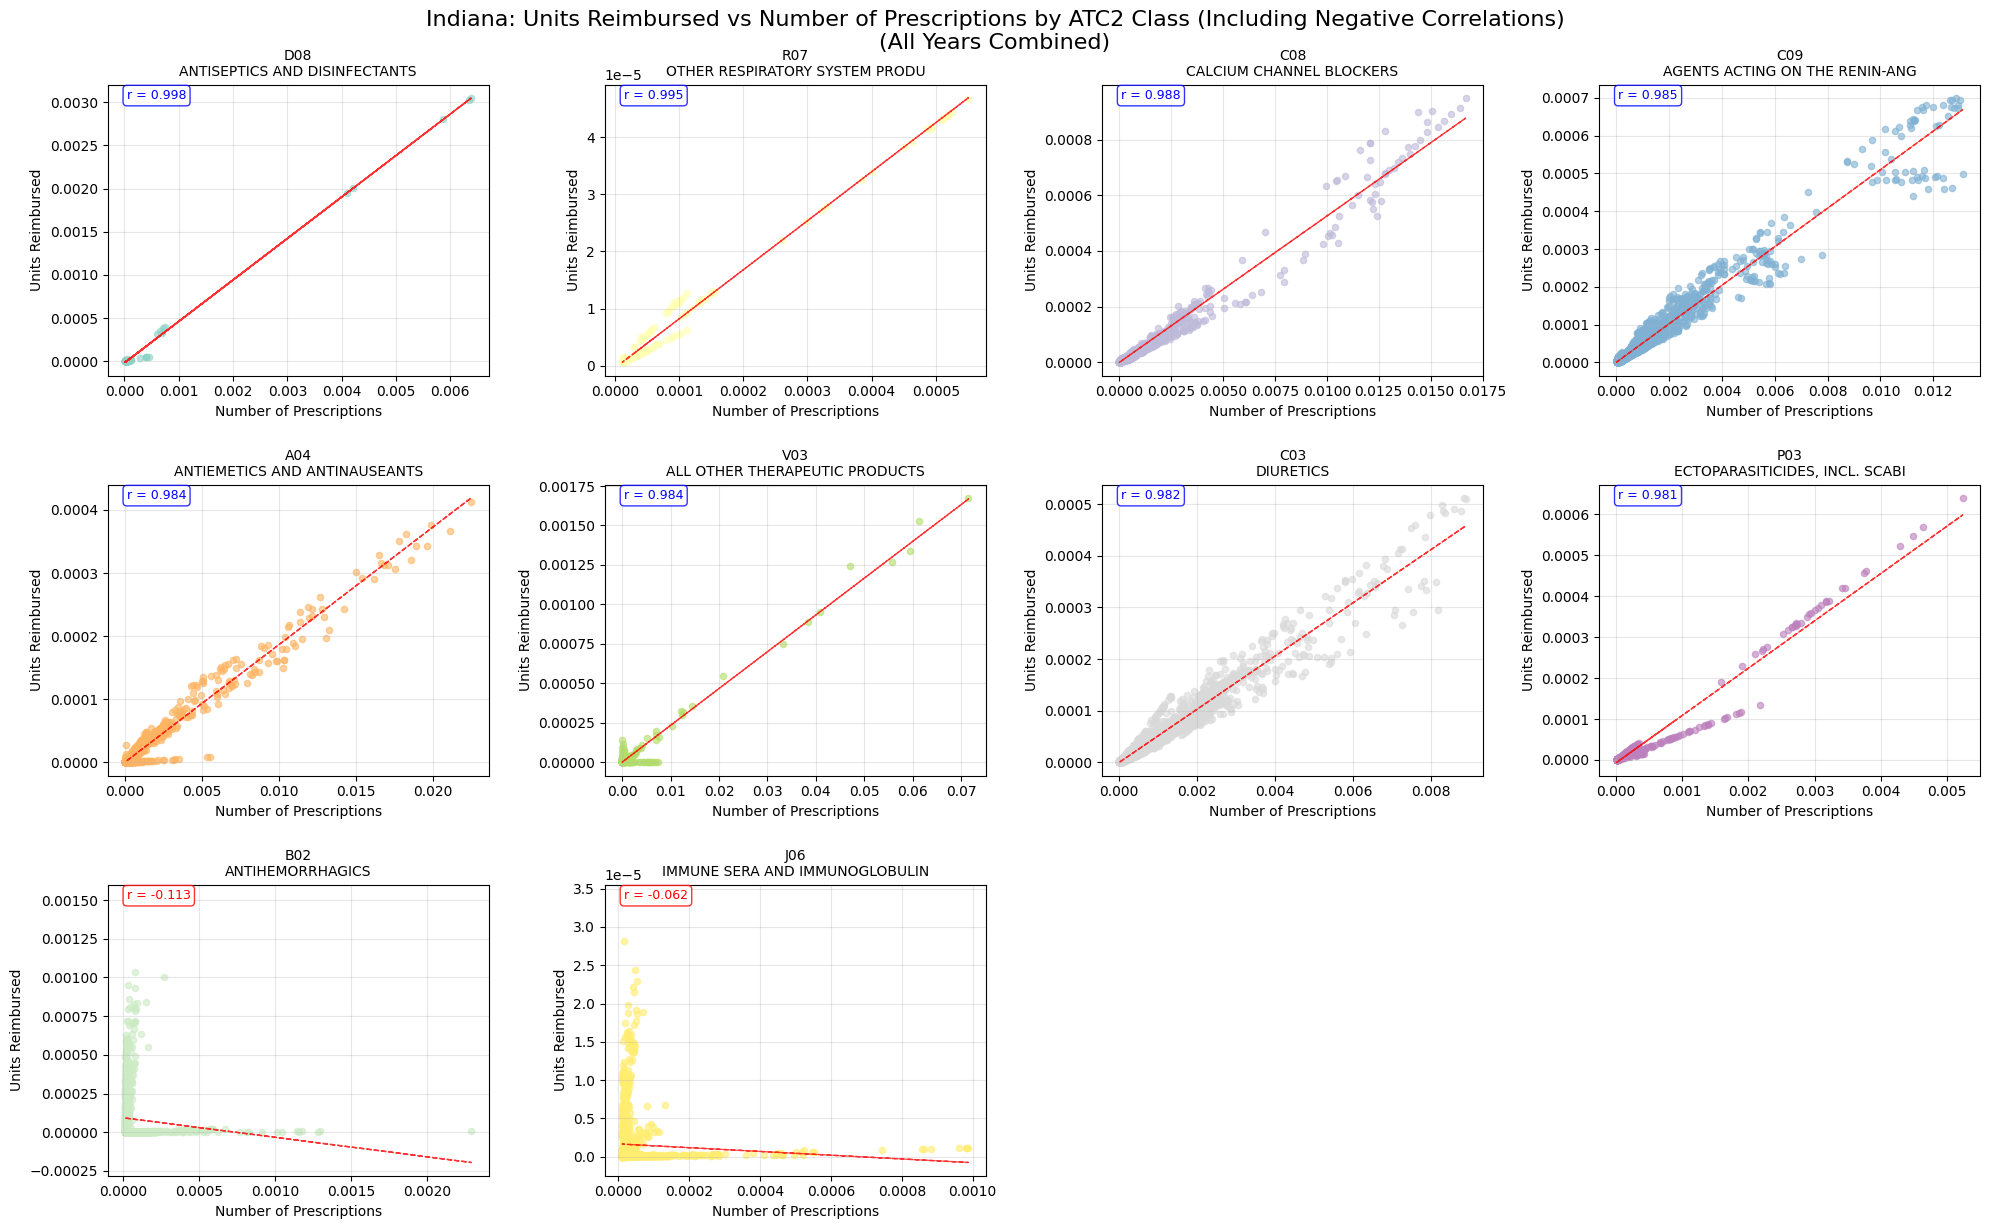


PLOT SUMMARY - INDIANA ATC CLASSES
ATC2  Name                           Records  Correlation  Type    
------------------------------------------------------------------------------------------
D08   ANTISEPTICS AND DISINFECTANT   104      0.9985       Positive
R07   OTHER RESPIRATORY SYSTEM PRO   178      0.9946       Positive
C08   CALCIUM CHANNEL BLOCKERS       5591     0.9885       Positive
C09   AGENTS ACTING ON THE RENIN-A   11667    0.9850       Positive
A04   ANTIEMETICS AND ANTINAUSEANT   3835     0.9844       Positive
V03   ALL OTHER THERAPEUTIC PRODUC   1999     0.9836       Positive
C03   DIURETICS                      10064    0.9823       Positive
P03   ECTOPARASITICIDES, INCL. SCA   449      0.9807       Positive
B02   ANTIHEMORRHAGICS               1101     -0.1128      Negative
J06   IMMUNE SERA AND IMMUNOGLOBUL   1290     -0.0619      Negative
CORRELATION ANALYSIS: Units Reimbursed vs Number of Prescriptions
INDIANA ONLY - By ATC Class
Processing 2017... ✓ (52,812 re

In [10]:
years_to_analyze = [2017,2018,2019, 2020, 2021, 2022, 2023, 2024]
#first plotting and then seeing correlation results
plot_data = NDCATC_ind.plot_units_vs_prescriptions_by_atc(years_to_analyze)
correlation_results = NDCATC_ind.analyze_correlation_by_state_atc(years_to_analyze)


In [ ]:
class NDCATC_comparative:
    @staticmethod
    def compare_cumulative_80_analysis(base_path=None, cumulative_threshold=80.0):
        """
        Compare Indiana vs National ATC2 classes that reach 80% cumulative percentage
        for both Units Reimbursed and Prescriptions.
        """
        if base_path is None:
            base_path = rf"c:\Users\{user}\OneDrive - purdue.edu\VS code\Data"
        
        print("COMPARATIVE ANALYSIS: Indiana vs National ATC2 Classes at 80% Cumulative Threshold")
        print("="*85)
        
        # File paths
        indiana_file = os.path.join(base_path, "ATC\\exported_analysis\\ATC2_Cumulative_Analysis_IN_with_NDC_Counts.xlsx")
        national_file = os.path.join(base_path, "ATC\\exported_analysis\\ATC2_Cumulative_Analysis_with_NDC_Counts.xlsx")
        
        try:
            # Load Indiana data
            indiana_units = pd.read_excel(indiana_file, sheet_name='Units_Reimbursed')
            indiana_prescriptions = pd.read_excel(indiana_file, sheet_name='Prescriptions')
            
            # Load National data
            national_units = pd.read_excel(national_file, sheet_name='Units_Reimbursed')
            national_prescriptions = pd.read_excel(national_file, sheet_name='Prescriptions')
            
            print(f"✓ Loaded Indiana data: {len(indiana_units)} ATC2 classes")
            print(f"✓ Loaded National data: {len(national_units)} ATC2 classes")
            
        except FileNotFoundError as e:
            print(f"✗ Error: Could not find required Excel files.")
            print(f"  Expected files:")
            print(f"  - {indiana_file}")
            print(f"  - {national_file}")
            print(f"  Please run the export functions first.")
            return None
        except Exception as e:
            print(f"✗ Error loading files: {e}")
            return None
        
        def get_classes_at_threshold(df, metric_name, threshold=80.0):
            """Get ATC2 classes that collectively reach the cumulative percentage threshold"""
            # Find classes that reach the threshold
            if metric_name == 'Units':
                cumulative_col = 'Cumulative_Percentage'
            else:  # Prescriptions
                cumulative_col = 'Cumulative_Percentage'
            
            # Sort by cumulative percentage to ensure proper order
            df_sorted = df.sort_values('Cumulative_Percentage').reset_index(drop=True)
            
            # Find the index where cumulative percentage first exceeds threshold
            threshold_index = df_sorted[df_sorted[cumulative_col] >= threshold].index
            
            if len(threshold_index) > 0:
                # Include all classes up to and including the first one that reaches/exceeds threshold
                cutoff_idx = threshold_index[0]
                classes_at_threshold = df_sorted.iloc[:cutoff_idx + 1]['ATC_Class'].tolist()
            else:
                # If no class reaches threshold, include all classes
                classes_at_threshold = df_sorted['ATC_Class'].tolist()
            
            return classes_at_threshold
        
        # 1. INDIANA ANALYSIS
        print(f"\n{'='*60}")
        print("1. INDIANA ANALYSIS")
        print(f"{'='*60}")
        
        in_units_80 = get_classes_at_threshold(indiana_units, 'Units', cumulative_threshold)
        in_prescriptions_80 = get_classes_at_threshold(indiana_prescriptions, 'Prescriptions', cumulative_threshold)
        
        print(f"\nIndiana - Classes reaching {cumulative_threshold}% cumulative:")
        print(f"Units Reimbursed: {len(in_units_80)} classes")
        print(f"Prescriptions: {len(in_prescriptions_80)} classes")
        
        # Find overlap and differences for Indiana
        in_overlap = set(in_units_80) & set(in_prescriptions_80)
        in_only_units = set(in_units_80) - set(in_prescriptions_80)
        in_only_prescriptions = set(in_prescriptions_80) - set(in_units_80)
        
        print(f"\nIndiana Comparison:")
        print(f"Overlap (both metrics): {len(in_overlap)} classes")
        print(f"Only in Units: {len(in_only_units)} classes")
        print(f"Only in Prescriptions: {len(in_only_prescriptions)} classes")
        
        # 2. NATIONAL ANALYSIS
        print(f"\n{'='*60}")
        print("2. NATIONAL ANALYSIS")
        print(f"{'='*60}")
        
        nat_units_80 = get_classes_at_threshold(national_units, 'Units', cumulative_threshold)
        nat_prescriptions_80 = get_classes_at_threshold(national_prescriptions, 'Prescriptions', cumulative_threshold)
        
        print(f"\nNational - Classes reaching {cumulative_threshold}% cumulative:")
        print(f"Units Reimbursed: {len(nat_units_80)} classes")
        print(f"Prescriptions: {len(nat_prescriptions_80)} classes")
        
        # Find overlap and differences for National
        nat_overlap = set(nat_units_80) & set(nat_prescriptions_80)
        nat_only_units = set(nat_units_80) - set(nat_prescriptions_80)
        nat_only_prescriptions = set(nat_prescriptions_80) - set(nat_units_80)
        
        print(f"\nNational Comparison:")
        print(f"Overlap (both metrics): {len(nat_overlap)} classes")
        print(f"Only in Units: {len(nat_only_units)} classes")
        print(f"Only in Prescriptions: {len(nat_only_prescriptions)} classes")
        
        # 3. COMPARATIVE SUMMARY TABLE
        print(f"\n{'='*85}")
        print("3. COMPARATIVE SUMMARY TABLE")
        print(f"{'='*85}")
        
        # Create summary table
        summary_data = {
            'Metric': ['Units Reimbursed', 'Prescriptions', 'Overlap (Both)', 'Only Units', 'Only Prescriptions'],
            'Indiana_Classes': [
                len(in_units_80),
                len(in_prescriptions_80), 
                len(in_overlap),
                len(in_only_units),
                len(in_only_prescriptions)
            ],
            'National_Classes': [
                len(nat_units_80),
                len(nat_prescriptions_80),
                len(nat_overlap),
                len(nat_only_units),
                len(nat_only_prescriptions)
            ]
        }
        
        summary_df = pd.DataFrame(summary_data)
        summary_df['Difference'] = summary_df['National_Classes'] - summary_df['Indiana_Classes']
        summary_df['IN_Percentage'] = (summary_df['Indiana_Classes'] / summary_df['Indiana_Classes'].iloc[0] * 100).round(1)
        summary_df['National_Percentage'] = (summary_df['National_Classes'] / summary_df['National_Classes'].iloc[0] * 100).round(1)
        
        print(f"\nSUMMARY: Classes reaching {cumulative_threshold}% cumulative threshold")
        print(summary_df.to_string(index=False))
        
        # 4. DETAILED CLASS LISTS
        print(f"\n{'='*85}")
        print("4. DETAILED ATC2 CLASS ANALYSIS")
        print(f"{'='*85}")
        
        # Create detailed comparison
        def create_detailed_comparison(in_list, nat_list, metric_name):
            print(f"\n{metric_name.upper()} - Detailed Comparison:")
            print("-" * 50)
            
            in_set = set(in_list)
            nat_set = set(nat_list)
            
            overlap = in_set & nat_set
            only_indiana = in_set - nat_set
            only_national = nat_set - in_set
            
            print(f"Classes in BOTH Indiana and National ({len(overlap)}):")
            if overlap:
                for cls in sorted(overlap):
                    print(f"  {cls}")
            else:
                print("  None")
            
            print(f"\nClasses ONLY in Indiana ({len(only_indiana)}):")
            if only_indiana:
                for cls in sorted(only_indiana):
                    print(f"  {cls}")
            else:
                print("  None")
            
            print(f"\nClasses ONLY in National ({len(only_national)}):")
            if only_national:
                for cls in sorted(only_national):
                    print(f"  {cls}")
            else:
                print("  None")
        
        create_detailed_comparison(in_units_80, nat_units_80, "Units Reimbursed")
        create_detailed_comparison(in_prescriptions_80, nat_prescriptions_80, "Prescriptions")
        
        # 5. CROSS-METRIC COMPARISON
        print(f"\n{'='*85}")
        print("5. CROSS-METRIC COMPARISON (Units vs Prescriptions)")
        print(f"{'='*85}")
        
        print(f"\nINDIANA - Units vs Prescriptions overlap analysis:")
        print(f"Classes in BOTH Units and Prescriptions ({len(in_overlap)}):")
        if in_overlap:
            for cls in sorted(in_overlap):
                print(f"  {cls}")
        else:
            print("  None")
        
        print(f"\nClasses ONLY in Units Reimbursed ({len(in_only_units)}):")
        if in_only_units:
            for cls in sorted(in_only_units):
                print(f"  {cls}")
        else:
            print("  None")
        
        print(f"\nClasses ONLY in Prescriptions ({len(in_only_prescriptions)}):")
        if in_only_prescriptions:
            for cls in sorted(in_only_prescriptions):
                print(f"  {cls}")
        else:
            print("  None")
        
        print(f"\nNATIONAL - Units vs Prescriptions overlap analysis:")
        print(f"Classes in BOTH Units and Prescriptions ({len(nat_overlap)}):")
        if nat_overlap:
            for cls in sorted(nat_overlap):
                print(f"  {cls}")
        else:
            print("  None")
        
        print(f"\nClasses ONLY in Units Reimbursed ({len(nat_only_units)}):")
        if nat_only_units:
            for cls in sorted(nat_only_units):
                print(f"  {cls}")
        else:
            print("  None")
        
        print(f"\nClasses ONLY in Prescriptions ({len(nat_only_prescriptions)}):")
        if nat_only_prescriptions:
            for cls in sorted(nat_only_prescriptions):
                print(f"  {cls}")
        else:
            print("  None")
        
        # Return comprehensive results
        results = {
            'summary_table': summary_df,
            'indiana': {
                'units_80': in_units_80,
                'prescriptions_80': in_prescriptions_80,
                'overlap': list(in_overlap),
                'only_units': list(in_only_units),
                'only_prescriptions': list(in_only_prescriptions)
            },
            'national': {
                'units_80': nat_units_80,
                'prescriptions_80': nat_prescriptions_80,
                'overlap': list(nat_overlap),
                'only_units': list(nat_only_units),
                'only_prescriptions': list(nat_only_prescriptions)
            }
        }
        
        print(f"\n{'='*85}")
        print("ANALYSIS COMPLETE")
        print(f"{'='*85}")
        
        return results

In [8]:
# Run the comparative analysis
comparison_results = NDCATC_comparative.compare_cumulative_80_analysis()

COMPARATIVE ANALYSIS: Indiana vs National ATC2 Classes at 80% Cumulative Threshold
✓ Loaded Indiana data: 86 ATC2 classes
✓ Loaded National data: 90 ATC2 classes

1. INDIANA ANALYSIS

Indiana - Classes reaching 80.0% cumulative:
Units Reimbursed: 21 classes
Prescriptions: 26 classes

Indiana Comparison:
Overlap (both metrics): 21 classes
Only in Units: 0 classes
Only in Prescriptions: 5 classes

2. NATIONAL ANALYSIS

National - Classes reaching 80.0% cumulative:
Units Reimbursed: 23 classes
Prescriptions: 28 classes

National Comparison:
Overlap (both metrics): 23 classes
Only in Units: 0 classes
Only in Prescriptions: 5 classes

3. COMPARATIVE SUMMARY TABLE

SUMMARY: Classes reaching 80.0% cumulative threshold
            Metric  Indiana_Classes  National_Classes  Difference  IN_Percentage  National_Percentage
  Units Reimbursed               21                23           2          100.0                100.0
     Prescriptions               26                28           2          

In [ ]:
# First let's verify what the current method is doing exactly
# Let's create a test to see the cumulative percentages

def test_cumulative_logic():
    """Test function to understand how cumulative percentages work in our data"""
    import os
    
    base_path = rf"c:\Users\{user}\OneDrive - purdue.edu\VS code\Data"
    indiana_file = os.path.join(base_path, "ATC\\exported_analysis\\ATC2_Cumulative_Analysis_IN_with_NDC_Counts.xlsx")
    
    try:
        # Load Indiana Units data as example
        indiana_units = pd.read_excel(indiana_file, sheet_name='Units_Reimbursed')
        
        print("UNDERSTANDING CUMULATIVE PERCENTAGE LOGIC")
        print("="*60)
        print(f"Total ATC2 classes in Indiana Units: {len(indiana_units)}")
        
        # Show first 10 rows to understand the data structure
        print(f"\nFirst 10 classes (showing cumulative progression):")
        print(indiana_units[['ATC_Class', 'Percentage', 'Cumulative_Percentage']].head(10).to_string(index=False))
        
        # Find classes around 80%
        around_80 = indiana_units[(indiana_units['Cumulative_Percentage'] >= 75) & 
                                 (indiana_units['Cumulative_Percentage'] <= 85)]
        print(f"\nClasses around 80% cumulative (75%-85%):")
        if not around_80.empty:
            print(around_80[['ATC_Class', 'Percentage', 'Cumulative_Percentage']].to_string(index=False))
        else:
            print("No classes found in this range")
        
        # Current method result
        classes_old_method = indiana_units[indiana_units['Cumulative_Percentage'] <= 80]['ATC_Class'].tolist()
        print(f"\nOLD METHOD (<=80%): {len(classes_old_method)} classes")
        
        # New method result
        threshold_index = indiana_units[indiana_units['Cumulative_Percentage'] >= 80].index
        if len(threshold_index) > 0:
            cutoff_idx = threshold_index[0]
            classes_new_method = indiana_units.iloc[:cutoff_idx + 1]['ATC_Class'].tolist()
            final_cumulative = indiana_units.iloc[cutoff_idx]['Cumulative_Percentage']
            print(f"NEW METHOD (first to reach >=80%): {len(classes_new_method)} classes")
            print(f"Final cumulative percentage reached: {final_cumulative:.2f}%")
        else:
            print("NEW METHOD: No classes reach 80%")
            
    except FileNotFoundError:
        print("Excel file not found. Please run the export functions first.")
    except Exception as e:
        print(f"Error: {e}")

# Run the test
test_cumulative_logic()